# Quantum Hadamard Edge Detection

### Imports and Setup

In [19]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")


### Set up provider and backend access

Due to the size of the image and the chunks, we will use a simulator instead of an actual quantum computer.

In [20]:
provider = IBMQ.load_account()
backend = Aer.get_backend('statevector_simulator')

ibmqfactory.load_account:WARNING:2023-05-30 12:58:31,012: Credentials are already in use. The existing account in the session will be replaced.


### Load image

After loading the image and storing it as a numpy array, we convert the image to black & white for easier representation of the image. We then split it into chunks that are small enough to be processed using the quantum computer (or simulator in this case).

Raw Image info: (256, 256, 3)
Raw Image datatype: uint8
Image shape (numpy array): (256, 256)


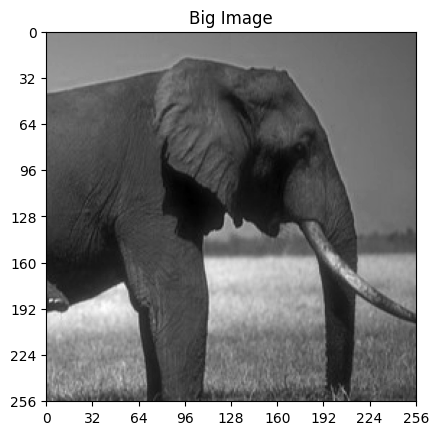

In [30]:
from PIL import Image
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('Final_project/elephant.jpg'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
          
image = np.array(image)
print('Image shape (numpy array):', image.shape)

# Split the overall image into chunks of size image_crop_size x image_crop_size
imgmat = []

for n in range(int(image_size / image_crop_size)):
    imgmat.append([])
    for m in range(int(image_size / image_crop_size) ):
        lx = int(n * image_crop_size)
        ux = int((n + 1) * image_crop_size)
        ly = int(m * image_crop_size)
        uy = int((m + 1) * image_crop_size)
        imgmat[n].append(image[lx:ux, ly:uy])
        



# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='gray')
plt.show()

### Define probability amplitude extraction

This function normalizes the brightness values of the image to make a valid statevector. 

In [31]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    if rms == 0: # exception for all 0's (i.e. a blank image) to prevent divide by 0 errors
        return np.array(img_data)
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

### Defining number qubits and preparing the oracle

In [32]:
# Initialize some global variable for number of qubits
total_qb = 11

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

## Processing

This code block does the actual work of the algorithm. Running it may take several minutes.

We set up an array for the horizontal and vertical scans of the chunks. Then, for each chunk, we generate its statevector and run it through the QHED algorithm twice - once for the horizontal scan, and once for the vertical by running the same circuit on the transpose of the original chunk. (If the chunk is all 0's, we skip this, as there are obviously no edges to detect in an empty chunk.)

Once the algorithm has finished, we convert the results to binary using a threshold for "ON" values. We have found a threshold of +/- 1e-3 (1/1000) to produce the best results.

In [33]:
# Create the circuit for horizontal scan

horiz_scan = []
vert_scan = []
# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 1e-3 or amp < -1e-3)
for x in range(int(image_size / image_crop_size)):
    horiz_scan.append([])
    vert_scan.append([])
    for y in range(int(image_size / image_crop_size)):
        
        # Get the amplitude ancoded pixel values1
        # Horizontal: Original image
        image_norm_h = amplitude_encode(imgmat[x][y])

        # Vertical: Transpose of Original image
        image_norm_v = amplitude_encode(imgmat[x][y].T)
        
        if(image_norm_h.sum() != 0 and image_norm_v.sum() != 0):
            
            qc_h = QuantumCircuit(total_qb)
            qc_h.initialize(image_norm_h, range(1, total_qb))
            qc_h.h(0)
            qc_h.unitary(D2n_1, range(total_qb))
            qc_h.h(0)
            # display(qc_h.draw('mpl', fold=-1))

            # Create the circuit for vertical scan
            qc_v = QuantumCircuit(total_qb)
            qc_v.initialize(image_norm_v, range(1, total_qb))
            qc_v.h(0)
            qc_v.unitary(D2n_1, range(total_qb))
            qc_v.h(0)
            # display(qc_v.draw('mpl', fold=-1))

            # Combine both circuits into a single list
            circ_list = [qc_h, qc_v]

            # Simulating the cirucits
            job = execute(circ_list, backend=backend)
            results = job.result()
            sv_h = results.get_statevector(qc_h)
            sv_v = results.get_statevector(qc_v)


            # Classical postprocessing for plotting the output

            # Selecting odd states from the raw statevector and
            # reshaping column vector of size 64 to an 8x8 matrix
            edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**10)])).reshape(32, 32)
            edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**10)])).reshape(32, 32).T

        else:
            edge_scan_h = imgmat[x][y]
            edge_scan_v = imgmat[x][y].T
        horiz_scan[x].append(edge_scan_h)
        vert_scan[x].append(edge_scan_v)


### Overlaying the vertical and horizontal scans for each chunk

In [34]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = []
# horiz_scan | vert_scan
# for hrow in range(int(image_size / image_crop_size) - 1):
#     edge_scan_sim.append([])
#     for vrow in range(int(image_size / image_crop_size) - 1):
        
        
        
for i, (hrow, vrow) in enumerate(zip(horiz_scan, vert_scan)):
    edge_scan_sim.append([])
    for h, v in zip(hrow, vrow):
        edge_scan_sim[i].append(h.astype(int) | v.astype(int))
            
# edge_scan_sim
                

# Plotting the original and edge-detected images
#plot_image(image, 'Original image')
#plot_image(edge_scan_sim, 'Edge Detected image')

### Plot the results!

In [35]:
# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(0, img.shape[0]+1, 32))
    plt.yticks(range(0, img.shape[1]+1, 32))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='gray')
    plt.show()

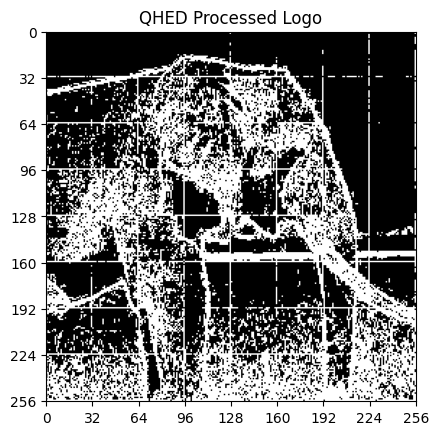

In [36]:
# recombine our array of chunks into a single image
edge_rows = [np.hstack(row) for row in edge_scan_sim]
edges = np.vstack(edge_rows)

plot_image(edges, 'QHED Processed Logo')